In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using CPU. Note: This module is much faster with a GPU.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ Detected Number Plate: SKOIPC0456


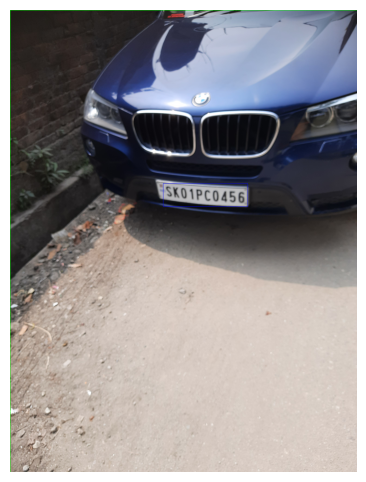

In [1]:
# =========================================================
# ROBUST INDIAN NUMBER PLATE RECOGNITION
# Plate Bounding Box + OCR Bounding Box
# =========================================================

import cv2
import matplotlib.pyplot as plt
import easyocr
import re

# ---------------------------------------------------------
# IMAGE LOCATION
# ---------------------------------------------------------
image_path = "/kaggle/input/indian-number-plates-dataset/Indian_Number_Plates/Sample_Images/Datacluster_number_plates (79).jpg"

# ---------------------------------------------------------
# READ IMAGE
# ---------------------------------------------------------
original_image = cv2.imread(image_path)
if original_image is None:
    raise FileNotFoundError("Image not found!")

annotated_image = original_image.copy()

# ---------------------------------------------------------
# IMAGE PREPROCESSING
# ---------------------------------------------------------
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
gray_image = cv2.resize(
    gray_image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC
)

binary_image = cv2.adaptiveThreshold(
    gray_image,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    11,
    2
)

# ---------------------------------------------------------
# LOCATE NUMBER PLATE CONTOUR
# ---------------------------------------------------------
all_contours, _ = cv2.findContours(
    binary_image,
    cv2.RETR_TREE,
    cv2.CHAIN_APPROX_SIMPLE
)

top_contours = sorted(
    all_contours, key=cv2.contourArea, reverse=True
)[:10]

number_plate_contour = None

for contour in top_contours:
    perimeter = cv2.arcLength(contour, True)
    approx_shape = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

    if len(approx_shape) == 4:
        number_plate_contour = approx_shape
        break

# ---------------------------------------------------------
# OCR + RULE-BASED CORRECTION
# ---------------------------------------------------------
ocr_engine = easyocr.Reader(['en'], gpu=False)

INDIAN_STATE_CODES = {
    "MH","KA","TN","DL","AP","TS","KL","GJ","RJ",
    "UP","MP","PB","HR","WB","OD","BR","CG","GA"
}

def normalize_plate_text(text):
    text = re.sub(r'[^A-Z0-9]', '', text)

    if len(text) < 8:
        return text

    detected_state = text[:2]

    state_fixes = {
        "HH": "MH",
        "IH": "MH",
        "MN": "MH",
        "NH": "MH"
    }

    if detected_state not in INDIAN_STATE_CODES:
        detected_state = state_fixes.get(detected_state, detected_state)

    return detected_state + text[2:]

final_plate_text = "Not Detected"

if number_plate_contour is not None:
    x, y, w, h = cv2.boundingRect(number_plate_contour)
    cropped_plate = original_image[y:y+h, x:x+w]

    ocr_results = ocr_engine.readtext(
        cropped_plate,
        allowlist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    )

    # ---- DRAW NUMBER PLATE BOUNDING BOX (GREEN) ----
    cv2.rectangle(
        annotated_image,
        (x, y),
        (x + w, y + h),
        (0, 255, 0),
        3
    )

    for (box, detected_text, confidence) in ocr_results:
        final_plate_text = normalize_plate_text(detected_text)

        # ---- DRAW OCR TEXT BOUNDING BOX (RED) ----
        top_left, _, bottom_right, _ = box

        tl = (int(top_left[0] + x), int(top_left[1] + y))
        br = (int(bottom_right[0] + x), int(bottom_right[1] + y))

        cv2.rectangle(
            annotated_image,
            tl,
            br,
            (255, 0, 0),
            2
        )

    # ---- DISPLAY FINAL PLATE TEXT ----
    cv2.putText(
        annotated_image,
        final_plate_text,
        (x, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 255),
        2
    )

# ---------------------------------------------------------
# OUTPUT
# ---------------------------------------------------------
print("✅ Detected Number Plate:", final_plate_text)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
